# Data Setup

In [1]:
import torch
from torchvision import transforms, datasets
import time
import copy
import os
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
import torchvision.models.quantization as qmodels
import torchvision.models as models


batch_size = 32
epochs = 20
stats_lst = []
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}


data_path = Path("data")
image_path = data_path / "EuroSAT_Split"

image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=os.cpu_count())
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\ERDT\AppData\Local\Temp\ipykernel_49940\1115181609.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions

In [2]:
## Imshow Function
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [3]:
## Imshow Sample
# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs, nrow=4)

#fig, ax = plt.subplots(1, figsize=(10, 10))
#imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [4]:
## Model Training Function
from tqdm import trange, tqdm_notebook
def train_model(model_name, model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    Support function for model training.
    
    Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in trange(num_epochs, desc = 'Epochs'):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        temp_lst = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                temp_lst +=[model_name, epoch, epoch_loss, epoch_acc]
            elif phase == 'val':
                temp_lst += [epoch_loss, epoch_acc]
                stats_lst.append(temp_lst)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
## Model Visualization Function
def visualize_model(model1, rows=3, cols=3):
    model = model1.to('cpu')
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            for jdx in range(imgs.size()[0]):
                imshow(imgs.data[jdx], ax=ax[current_row, current_col])
                ax[current_row, current_col].axis('off')
                ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))
                current_col += 1
                if current_col >= cols:
                    current_row += 1
                    current_col = 0
                if current_row >= rows:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
## Loss & Optimizer Function
def Optimizer_Setup(model: nn.Module, lr=0.01, momentum=0.9):
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    return criterion, optimizer_ft, exp_lr_scheduler

In [7]:
## Save Model Function
from pathlib import Path

def save_model(model: torch.nn.Module, model_name):
    # Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                     exist_ok=True # if models directory already exists, don't error
    )
    
    # Create model save path
    MODEL_NAME = model_name + ".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    # Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
               f=MODEL_SAVE_PATH)

In [8]:
## Export as ONNX function

def export_onnx(model_name, model: torch.nn.Module, batch_size):
    x = torch.randn(batch_size, 3, 64, 64).cpu()
    
    # Export the model
    torch.onnx.export(model,               # model being run
                      x,                         # model input (or a tuple for multiple inputs)
                      "models/"+model_name+".onnx",   # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=13,
                      input_names = ['RGB Image'],   # the model's input names
                      output_names = ['Land Cover Class'] # the model's output names
                     )
    print("Successfully exported model")

# Non-Quantized Models

## ResNet50

Epochs:   0%|                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.9132 Acc: 0.7293


Epochs:   5%|██████▊                                                                                                                                 | 1/20 [06:57<2:12:19, 417.89s/it]

val Loss: 0.3994 Acc: 0.8685

Epoch 1/19
----------
train Loss: 0.3917 Acc: 0.8660


Epochs:  10%|█████████████▌                                                                                                                          | 2/20 [13:52<2:04:51, 416.19s/it]

val Loss: 0.3816 Acc: 0.8693

Epoch 2/19
----------
train Loss: 0.2624 Acc: 0.9090


Epochs:  15%|████████████████████▍                                                                                                                   | 3/20 [20:46<1:57:36, 415.08s/it]

val Loss: 0.1908 Acc: 0.9328

Epoch 3/19
----------
train Loss: 0.2098 Acc: 0.9253


Epochs:  20%|███████████████████████████▏                                                                                                            | 4/20 [27:38<1:50:19, 413.74s/it]

val Loss: 0.2276 Acc: 0.9213

Epoch 4/19
----------
train Loss: 0.1741 Acc: 0.9406


Epochs:  25%|██████████████████████████████████                                                                                                      | 5/20 [34:27<1:43:02, 412.15s/it]

val Loss: 0.1710 Acc: 0.9409

Epoch 5/19
----------
train Loss: 0.1458 Acc: 0.9494


Epochs:  30%|████████████████████████████████████████▊                                                                                               | 6/20 [41:11<1:35:30, 409.29s/it]

val Loss: 0.1387 Acc: 0.9506

Epoch 6/19
----------
train Loss: 0.1316 Acc: 0.9540


Epochs:  35%|███████████████████████████████████████████████▌                                                                                        | 7/20 [47:53<1:28:09, 406.89s/it]

val Loss: 0.1556 Acc: 0.9483

Epoch 7/19
----------
train Loss: 0.0729 Acc: 0.9756


Epochs:  40%|██████████████████████████████████████████████████████▍                                                                                 | 8/20 [54:29<1:20:40, 403.40s/it]

val Loss: 0.0941 Acc: 0.9681

Epoch 8/19
----------
train Loss: 0.0594 Acc: 0.9813


Epochs:  45%|████████████████████████████████████████████████████████████▎                                                                         | 9/20 [1:01:01<1:13:18, 399.84s/it]

val Loss: 0.0911 Acc: 0.9702

Epoch 9/19
----------
train Loss: 0.0556 Acc: 0.9820


Epochs:  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 10/20 [1:07:31<1:06:09, 396.94s/it]

val Loss: 0.0900 Acc: 0.9693

Epoch 10/19
----------
train Loss: 0.0496 Acc: 0.9831


Epochs:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 11/20 [1:14:02<59:16, 395.11s/it]

val Loss: 0.0880 Acc: 0.9685

Epoch 11/19
----------
train Loss: 0.0490 Acc: 0.9830


Epochs:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 12/20 [1:20:33<52:29, 393.67s/it]

val Loss: 0.0864 Acc: 0.9711

Epoch 12/19
----------
train Loss: 0.0462 Acc: 0.9849


Epochs:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 13/20 [1:27:03<45:49, 392.82s/it]

val Loss: 0.0857 Acc: 0.9711

Epoch 13/19
----------
train Loss: 0.0430 Acc: 0.9851


Epochs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14/20 [1:33:33<39:10, 391.71s/it]

val Loss: 0.0808 Acc: 0.9728

Epoch 14/19
----------
train Loss: 0.0385 Acc: 0.9865


Epochs:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15/20 [1:40:01<32:34, 390.87s/it]

val Loss: 0.0818 Acc: 0.9720

Epoch 15/19
----------
train Loss: 0.0387 Acc: 0.9871


Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16/20 [1:46:30<26:01, 390.27s/it]

val Loss: 0.0801 Acc: 0.9726

Epoch 16/19
----------
train Loss: 0.0384 Acc: 0.9865


Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [1:53:00<19:29, 389.95s/it]

val Loss: 0.0826 Acc: 0.9722

Epoch 17/19
----------
train Loss: 0.0382 Acc: 0.9874


Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [1:59:29<12:59, 389.90s/it]

val Loss: 0.0803 Acc: 0.9735

Epoch 18/19
----------
train Loss: 0.0380 Acc: 0.9870


Epochs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [2:05:59<06:29, 389.81s/it]

val Loss: 0.0794 Acc: 0.9731

Epoch 19/19
----------
train Loss: 0.0361 Acc: 0.9887


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [2:12:29<00:00, 397.48s/it]

val Loss: 0.0799 Acc: 0.9728

Training complete in 132m 30s
Best val Acc: 0.973519


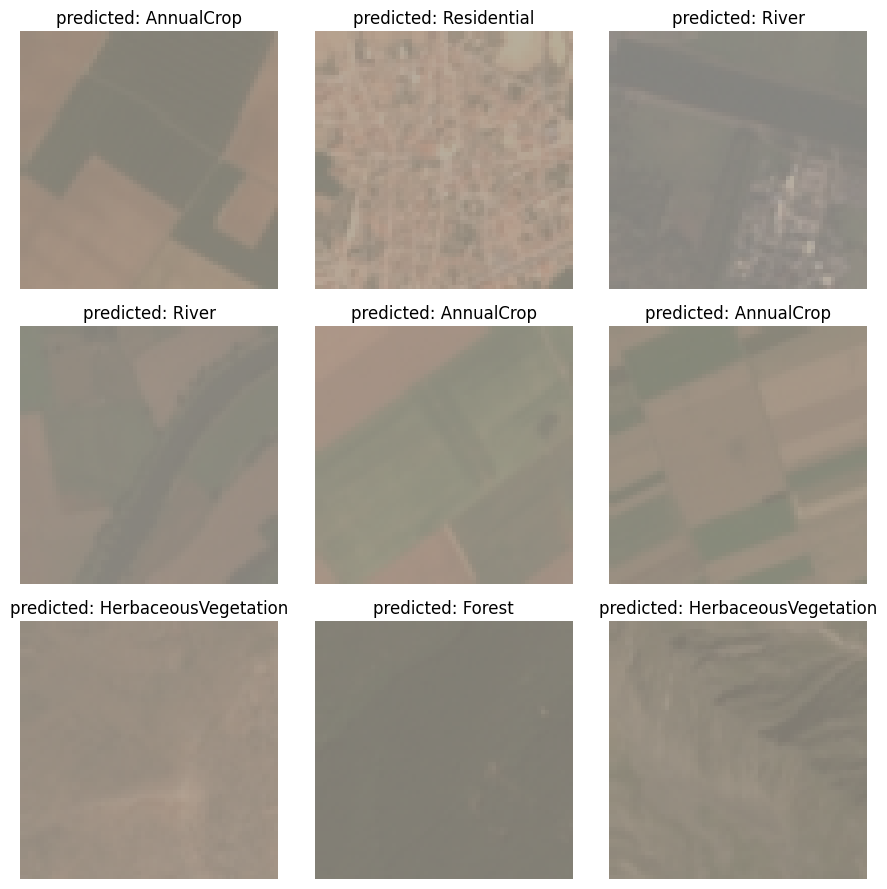

In [9]:
model_name = "ResNet50"
weights = models.ResNet50_Weights.DEFAULT
model_rn = models.resnet50(weights=weights).to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(model_rn)
new_model = train_model(model_name, model_rn, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [10]:
## Save ResNet50
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\ResNet50.pth
Successfully exported model


## MobileNetV3

Epochs:   0%|                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 1.2473 Acc: 0.5940


Epochs:   5%|██████▊                                                                                                                                 | 1/20 [03:43<1:10:53, 223.89s/it]

val Loss: 1.1476 Acc: 0.6096

Epoch 1/19
----------
train Loss: 0.7232 Acc: 0.7437


Epochs:  10%|█████████████▌                                                                                                                          | 2/20 [07:28<1:07:16, 224.28s/it]

val Loss: 0.6100 Acc: 0.7881

Epoch 2/19
----------
train Loss: 0.6080 Acc: 0.7886


Epochs:  15%|████████████████████▍                                                                                                                   | 3/20 [11:11<1:03:24, 223.80s/it]

val Loss: 0.5640 Acc: 0.7963

Epoch 3/19
----------
train Loss: 0.5005 Acc: 0.8250


Epochs:  20%|███████████████████████████▌                                                                                                              | 4/20 [14:55<59:42, 223.91s/it]

val Loss: 0.6843 Acc: 0.7781

Epoch 4/19
----------
train Loss: 0.4269 Acc: 0.8519


Epochs:  25%|██████████████████████████████████▌                                                                                                       | 5/20 [18:39<55:56, 223.80s/it]

val Loss: 0.4248 Acc: 0.8502

Epoch 5/19
----------
train Loss: 0.3705 Acc: 0.8714


Epochs:  30%|█████████████████████████████████████████▍                                                                                                | 6/20 [22:22<52:10, 223.62s/it]

val Loss: 0.3725 Acc: 0.8654

Epoch 6/19
----------
train Loss: 0.3323 Acc: 0.8836


Epochs:  35%|████████████████████████████████████████████████▎                                                                                         | 7/20 [26:06<48:27, 223.66s/it]

val Loss: 0.3491 Acc: 0.8748

Epoch 7/19
----------
train Loss: 0.2474 Acc: 0.9125


Epochs:  40%|███████████████████████████████████████████████████████▏                                                                                  | 8/20 [29:50<44:45, 223.81s/it]

val Loss: 0.2103 Acc: 0.9276

Epoch 8/19
----------
train Loss: 0.2264 Acc: 0.9203


Epochs:  45%|██████████████████████████████████████████████████████████████                                                                            | 9/20 [33:35<41:06, 224.22s/it]

val Loss: 0.2096 Acc: 0.9283

Epoch 9/19
----------
train Loss: 0.2246 Acc: 0.9212


Epochs:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 10/20 [37:19<37:22, 224.24s/it]

val Loss: 0.1945 Acc: 0.9339

Epoch 10/19
----------
train Loss: 0.2243 Acc: 0.9219


Epochs:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 11/20 [41:04<33:39, 224.40s/it]

val Loss: 0.1919 Acc: 0.9309

Epoch 11/19
----------
train Loss: 0.2158 Acc: 0.9230


Epochs:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 12/20 [44:47<29:50, 223.80s/it]

val Loss: 0.1904 Acc: 0.9315

Epoch 12/19
----------
train Loss: 0.2112 Acc: 0.9259


Epochs:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 13/20 [48:31<26:06, 223.84s/it]

val Loss: 0.1950 Acc: 0.9317

Epoch 13/19
----------
train Loss: 0.2053 Acc: 0.9276


Epochs:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14/20 [52:15<22:24, 224.07s/it]

val Loss: 0.1841 Acc: 0.9350

Epoch 14/19
----------
train Loss: 0.1994 Acc: 0.9295


Epochs:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15/20 [56:00<18:41, 224.26s/it]

val Loss: 0.1821 Acc: 0.9348

Epoch 15/19
----------
train Loss: 0.1970 Acc: 0.9318


Epochs:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16/20 [59:44<14:57, 224.37s/it]

val Loss: 0.1823 Acc: 0.9357

Epoch 16/19
----------
train Loss: 0.1980 Acc: 0.9299


Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [1:03:29<11:12, 224.33s/it]

val Loss: 0.1798 Acc: 0.9378

Epoch 17/19
----------
train Loss: 0.1885 Acc: 0.9343


Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [1:07:10<07:26, 223.47s/it]

val Loss: 0.1813 Acc: 0.9354

Epoch 18/19
----------
train Loss: 0.1925 Acc: 0.9335


Epochs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [1:10:53<03:43, 223.33s/it]

val Loss: 0.1806 Acc: 0.9369

Epoch 19/19
----------
train Loss: 0.1995 Acc: 0.9287


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:14:36<00:00, 223.84s/it]

val Loss: 0.1811 Acc: 0.9354

Training complete in 74m 37s
Best val Acc: 0.937778


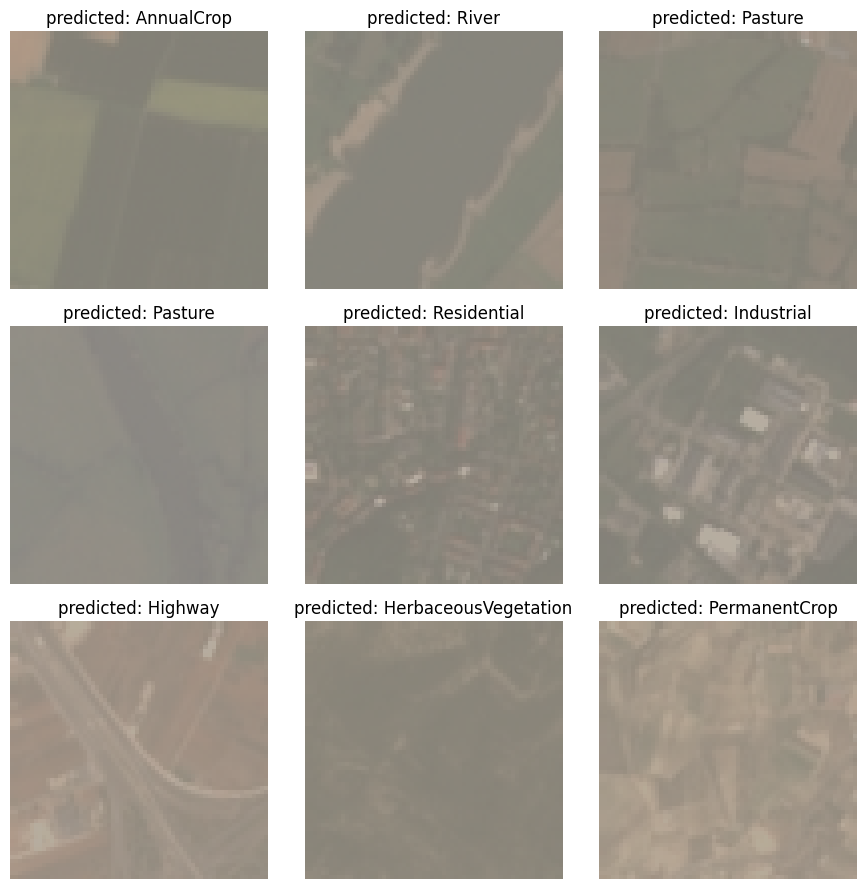

In [11]:
model_name = "MobileNetV3"
weights = models.MobileNet_V3_Large_Weights.DEFAULT
model_rn = models.mobilenet_v3_large(weights=weights).to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(model_rn)
new_model = train_model(model_name, model_rn, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [12]:
## Save MobileNetV3
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\MobileNetV3.pth
Successfully exported model


## GoogLeNet

Epochs:   0%|                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6766 Acc: 0.8101


Epochs:   5%|██████▊                                                                                                                                 | 1/20 [03:53<1:13:55, 233.46s/it]

val Loss: 0.2724 Acc: 0.9115

Epoch 1/19
----------
train Loss: 0.3733 Acc: 0.8844


Epochs:  10%|█████████████▌                                                                                                                          | 2/20 [07:48<1:10:15, 234.18s/it]

val Loss: 0.3563 Acc: 0.8889

Epoch 2/19
----------
train Loss: 0.2299 Acc: 0.9249


Epochs:  15%|████████████████████▍                                                                                                                   | 3/20 [11:42<1:06:22, 234.24s/it]

val Loss: 0.1566 Acc: 0.9483

Epoch 3/19
----------
train Loss: 0.2019 Acc: 0.9335


Epochs:  20%|███████████████████████████▏                                                                                                            | 4/20 [15:38<1:02:39, 234.99s/it]

val Loss: 0.1601 Acc: 0.9478

Epoch 4/19
----------
train Loss: 0.1692 Acc: 0.9444


Epochs:  25%|██████████████████████████████████▌                                                                                                       | 5/20 [19:35<58:55, 235.73s/it]

val Loss: 0.1885 Acc: 0.9430

Epoch 5/19
----------
train Loss: 0.1474 Acc: 0.9512


Epochs:  30%|█████████████████████████████████████████▍                                                                                                | 6/20 [23:42<55:54, 239.61s/it]

val Loss: 0.1243 Acc: 0.9589

Epoch 6/19
----------
train Loss: 0.1280 Acc: 0.9570


Epochs:  35%|████████████████████████████████████████████████▎                                                                                         | 7/20 [27:37<51:32, 237.90s/it]

val Loss: 0.1843 Acc: 0.9346

Epoch 7/19
----------
train Loss: 0.0753 Acc: 0.9762


Epochs:  40%|███████████████████████████████████████████████████████▏                                                                                  | 8/20 [31:31<47:20, 236.72s/it]

val Loss: 0.0688 Acc: 0.9781

Epoch 8/19
----------
train Loss: 0.0596 Acc: 0.9812


Epochs:  45%|██████████████████████████████████████████████████████████████                                                                            | 9/20 [35:26<43:18, 236.25s/it]

val Loss: 0.0657 Acc: 0.9787

Epoch 9/19
----------
train Loss: 0.0572 Acc: 0.9810


Epochs:  50%|████████████████████████████████████████████████████████████████████▌                                                                    | 10/20 [39:22<39:22, 236.23s/it]

val Loss: 0.0635 Acc: 0.9791

Epoch 10/19
----------
train Loss: 0.0530 Acc: 0.9827


Epochs:  55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 11/20 [43:19<35:27, 236.34s/it]

val Loss: 0.0646 Acc: 0.9783

Epoch 11/19
----------
train Loss: 0.0517 Acc: 0.9826


Epochs:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 12/20 [47:14<31:28, 236.03s/it]

val Loss: 0.0667 Acc: 0.9776

Epoch 12/19
----------
train Loss: 0.0432 Acc: 0.9849


Epochs:  65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 13/20 [51:10<27:31, 235.93s/it]

val Loss: 0.0655 Acc: 0.9778

Epoch 13/19
----------
train Loss: 0.0458 Acc: 0.9848


Epochs:  70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14/20 [55:04<23:32, 235.44s/it]

val Loss: 0.0657 Acc: 0.9785

Epoch 14/19
----------
train Loss: 0.0428 Acc: 0.9852


Epochs:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 15/20 [58:59<19:36, 235.25s/it]

val Loss: 0.0628 Acc: 0.9811

Epoch 15/19
----------
train Loss: 0.0407 Acc: 0.9859


Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16/20 [1:02:53<15:39, 235.00s/it]

val Loss: 0.0633 Acc: 0.9813

Epoch 16/19
----------
train Loss: 0.0411 Acc: 0.9859


Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [1:06:49<11:45, 235.10s/it]

val Loss: 0.0633 Acc: 0.9802

Epoch 17/19
----------
train Loss: 0.0396 Acc: 0.9871


Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [1:10:44<07:50, 235.11s/it]

val Loss: 0.0631 Acc: 0.9791

Epoch 18/19
----------
train Loss: 0.0406 Acc: 0.9866


Epochs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [1:14:39<03:55, 235.20s/it]

val Loss: 0.0626 Acc: 0.9800

Epoch 19/19
----------
train Loss: 0.0401 Acc: 0.9875


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:18:35<00:00, 235.78s/it]

val Loss: 0.0635 Acc: 0.9796

Training complete in 78m 36s
Best val Acc: 0.981296


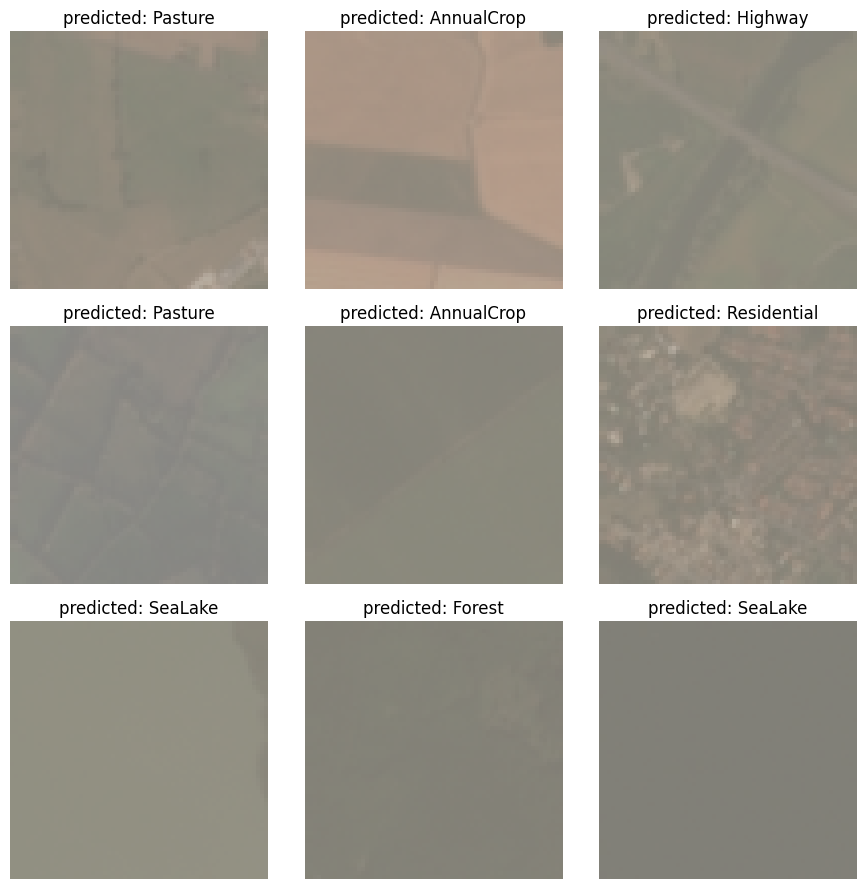

In [13]:
model_name = "GoogLeNet"
weights = models.GoogLeNet_Weights.DEFAULT
model_rn = models.googlenet(weights=weights).to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(model_rn)
new_model = train_model(model_name, model_rn, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [14]:
## Save GoogLeNet
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\GoogLeNet.pth
Successfully exported model


## Stats Non Quantized

In [15]:
stats = pd.DataFrame(stats_lst, columns = ['Model', 'Epoch', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Val Accuracy'])

In [16]:
stats.to_csv('StatsNQ.csv')

# Quantized Models

## ResNet50 Quantized

In [10]:
## Model Combination Function
def resnet_features(model_fe,num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

In [11]:
## ResNet50 Quantized
model_name = "ResNet50"
weights = qmodels.ResNet50_QuantizedWeights.DEFAULT
model_rn = qmodels.resnet50(weights=weights, quantize=True)
num_ftrs = model_rn.fc.in_features
new_model = resnet_features(model_rn,num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

Epochs:   0%|                                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6584 Acc: 0.8228


Epochs:   0%|                                                                                                                                                   | 0/20 [02:19<?, ?it/s]


KeyboardInterrupt: 

In [24]:
## Save ResNet50
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\ResNet50.pth
Successfully exported model


## MobileNetV3 Quantized

In [25]:
## Model Combination Function
def mobile_net_features(model_fe, num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.features,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

C:\Users\ERDT\anaconda3\envs\UNetEuroSATRGB\lib\site-packages\torch\ao\quantization\utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
Epochs:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.5525 Acc: 0.8189


Epochs:   5%|██▍                                              | 1/20 [03:39<1:09:33, 219.68s/it]

val Loss: 0.4141 Acc: 0.8622

Epoch 1/19
----------
train Loss: 0.4178 Acc: 0.8570


Epochs:  10%|████▉                                            | 2/20 [07:25<1:07:00, 223.39s/it]

val Loss: 0.3894 Acc: 0.8680

Epoch 2/19
----------
train Loss: 0.3961 Acc: 0.8658


Epochs:  15%|███████▎                                         | 3/20 [11:12<1:03:42, 224.86s/it]

val Loss: 0.3591 Acc: 0.8796

Epoch 3/19
----------
train Loss: 0.3772 Acc: 0.8728


Epochs:  20%|██████████▏                                        | 4/20 [14:54<59:39, 223.75s/it]

val Loss: 0.3662 Acc: 0.8731

Epoch 4/19
----------
train Loss: 0.3651 Acc: 0.8748


Epochs:  25%|████████████▊                                      | 5/20 [18:40<56:08, 224.56s/it]

val Loss: 0.3517 Acc: 0.8813

Epoch 5/19
----------
train Loss: 0.3598 Acc: 0.8761


Epochs:  30%|███████████████▎                                   | 6/20 [22:33<53:04, 227.46s/it]

val Loss: 0.3548 Acc: 0.8774

Epoch 6/19
----------
train Loss: 0.3511 Acc: 0.8783


Epochs:  35%|█████████████████▊                                 | 7/20 [26:12<48:42, 224.78s/it]

val Loss: 0.3478 Acc: 0.8826

Epoch 7/19
----------
train Loss: 0.3344 Acc: 0.8846


Epochs:  40%|████████████████████▍                              | 8/20 [29:50<44:30, 222.57s/it]

val Loss: 0.3323 Acc: 0.8878

Epoch 8/19
----------
train Loss: 0.3269 Acc: 0.8871


Epochs:  45%|██████████████████████▉                            | 9/20 [33:49<41:45, 227.73s/it]

val Loss: 0.3304 Acc: 0.8870

Epoch 9/19
----------
train Loss: 0.3248 Acc: 0.8866


Epochs:  50%|█████████████████████████                         | 10/20 [37:27<37:27, 224.75s/it]

val Loss: 0.3291 Acc: 0.8883

Epoch 10/19
----------
train Loss: 0.3289 Acc: 0.8856


Epochs:  55%|███████████████████████████▌                      | 11/20 [41:22<34:10, 227.81s/it]

val Loss: 0.3284 Acc: 0.8876

Epoch 11/19
----------
train Loss: 0.3218 Acc: 0.8888


Epochs:  60%|██████████████████████████████                    | 12/20 [45:07<30:14, 226.86s/it]

val Loss: 0.3286 Acc: 0.8880

Epoch 12/19
----------
train Loss: 0.3277 Acc: 0.8884


Epochs:  65%|████████████████████████████████▌                 | 13/20 [48:50<26:20, 225.79s/it]

val Loss: 0.3310 Acc: 0.8880

Epoch 13/19
----------
train Loss: 0.3226 Acc: 0.8886


Epochs:  70%|███████████████████████████████████               | 14/20 [52:29<22:22, 223.74s/it]

val Loss: 0.3285 Acc: 0.8904

Epoch 14/19
----------
train Loss: 0.3232 Acc: 0.8897


Epochs:  75%|█████████████████████████████████████▌            | 15/20 [56:02<18:22, 220.58s/it]

val Loss: 0.3273 Acc: 0.8893

Epoch 15/19
----------
train Loss: 0.3233 Acc: 0.8889


Epochs:  80%|████████████████████████████████████████          | 16/20 [59:41<14:40, 220.06s/it]

val Loss: 0.3271 Acc: 0.8893

Epoch 16/19
----------
train Loss: 0.3191 Acc: 0.8909


Epochs:  85%|████████████████████████████████████████▊       | 17/20 [1:03:10<10:50, 216.71s/it]

val Loss: 0.3274 Acc: 0.8896

Epoch 17/19
----------
train Loss: 0.3261 Acc: 0.8860


Epochs:  90%|███████████████████████████████████████████▏    | 18/20 [1:06:58<07:20, 220.11s/it]

val Loss: 0.3272 Acc: 0.8893

Epoch 18/19
----------
train Loss: 0.3205 Acc: 0.8891


Epochs:  95%|█████████████████████████████████████████████▌  | 19/20 [1:10:41<03:40, 220.85s/it]

val Loss: 0.3272 Acc: 0.8891

Epoch 19/19
----------
train Loss: 0.3278 Acc: 0.8876


Epochs: 100%|████████████████████████████████████████████████| 20/20 [1:14:39<00:00, 223.96s/it]

val Loss: 0.3272 Acc: 0.8889

Training complete in 74m 39s
Best val Acc: 0.890370


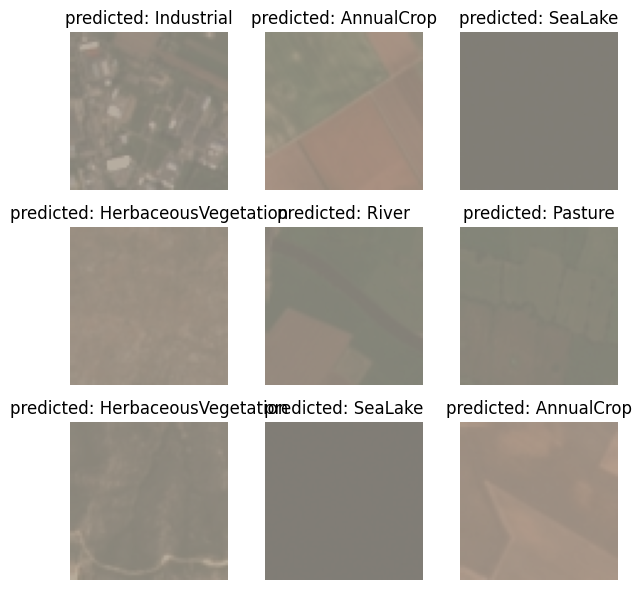

In [26]:
## MobileNetV3 Quantized
model_name = "MobileNetV3"
weights = qmodels.MobileNet_V3_Large_QuantizedWeights.DEFAULT
model_rn = qmodels.mobilenet_v3_large(weights=weights, quantize=True)
num_ftrs = model_rn.classifier[0].in_features
new_model = mobile_net_features(model_rn, num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [27]:
## Save MobileNetV3
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\MobileNetV3.pth
Successfully exported model


## GoogLeNet Quantized

In [28]:
## Model Combination Function
def google_net_features(model_fe, num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.conv1,
        model_fe.maxpool1,
        model_fe.conv2,
        model_fe.conv3,
        model_fe.maxpool2,
        model_fe.inception3a,
        model_fe.inception3b,
        model_fe.maxpool3,
        model_fe.inception4a,
        model_fe.inception4b,
        model_fe.inception4c,
        model_fe.inception4d,
        model_fe.inception4e,
        model_fe.maxpool4,
        model_fe.inception5a,
        model_fe.inception5b,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

Epochs:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6632 Acc: 0.7888


Epochs:   5%|██▍                                              | 1/20 [03:23<1:04:35, 203.98s/it]

val Loss: 0.5937 Acc: 0.8133

Epoch 1/19
----------
train Loss: 0.5689 Acc: 0.8242


Epochs:  10%|████▉                                            | 2/20 [06:41<1:00:01, 200.07s/it]

val Loss: 0.4938 Acc: 0.8387

Epoch 2/19
----------
train Loss: 0.5456 Acc: 0.8348


Epochs:  15%|███████▋                                           | 3/20 [10:05<57:14, 202.05s/it]

val Loss: 0.4885 Acc: 0.8448

Epoch 3/19
----------
train Loss: 0.5254 Acc: 0.8392


Epochs:  20%|██████████▏                                        | 4/20 [13:47<55:55, 209.70s/it]

val Loss: 0.5048 Acc: 0.8394

Epoch 4/19
----------
train Loss: 0.5208 Acc: 0.8401


Epochs:  25%|████████████▊                                      | 5/20 [17:09<51:45, 207.01s/it]

val Loss: 0.4759 Acc: 0.8465

Epoch 5/19
----------
train Loss: 0.5370 Acc: 0.8395


Epochs:  30%|███████████████▎                                   | 6/20 [20:38<48:27, 207.67s/it]

val Loss: 0.6070 Acc: 0.8300

Epoch 6/19
----------
train Loss: 0.5091 Acc: 0.8452


Epochs:  35%|█████████████████▊                                 | 7/20 [24:04<44:51, 207.06s/it]

val Loss: 0.5399 Acc: 0.8383

Epoch 7/19
----------
train Loss: 0.4174 Acc: 0.8670


Epochs:  40%|████████████████████▍                              | 8/20 [27:23<40:55, 204.66s/it]

val Loss: 0.4068 Acc: 0.8669

Epoch 8/19
----------
train Loss: 0.3971 Acc: 0.8713


Epochs:  45%|██████████████████████▉                            | 9/20 [30:59<38:08, 208.01s/it]

val Loss: 0.3937 Acc: 0.8698

Epoch 9/19
----------
train Loss: 0.3825 Acc: 0.8738


Epochs:  50%|█████████████████████████                         | 10/20 [34:23<34:28, 206.90s/it]

val Loss: 0.3905 Acc: 0.8706

Epoch 10/19
----------
train Loss: 0.3799 Acc: 0.8726


Epochs:  55%|███████████████████████████▌                      | 11/20 [37:48<30:57, 206.38s/it]

val Loss: 0.3909 Acc: 0.8719

Epoch 11/19
----------
train Loss: 0.3851 Acc: 0.8703


Epochs:  60%|██████████████████████████████                    | 12/20 [41:05<27:08, 203.52s/it]

val Loss: 0.3838 Acc: 0.8698

Epoch 12/19
----------
train Loss: 0.3751 Acc: 0.8742


Epochs:  65%|████████████████████████████████▌                 | 13/20 [44:24<23:35, 202.16s/it]

val Loss: 0.3863 Acc: 0.8693

Epoch 13/19
----------
train Loss: 0.3738 Acc: 0.8727


Epochs:  70%|███████████████████████████████████               | 14/20 [48:08<20:52, 208.79s/it]

val Loss: 0.3841 Acc: 0.8693

Epoch 14/19
----------
train Loss: 0.3606 Acc: 0.8790


Epochs:  75%|█████████████████████████████████████▌            | 15/20 [51:23<17:02, 204.56s/it]

val Loss: 0.3806 Acc: 0.8709

Epoch 15/19
----------
train Loss: 0.3685 Acc: 0.8737


Epochs:  80%|████████████████████████████████████████          | 16/20 [54:43<13:33, 203.27s/it]

val Loss: 0.3779 Acc: 0.8731

Epoch 16/19
----------
train Loss: 0.3708 Acc: 0.8741


Epochs:  85%|██████████████████████████████████████████▌       | 17/20 [58:29<10:30, 210.11s/it]

val Loss: 0.3766 Acc: 0.8728

Epoch 17/19
----------
train Loss: 0.3678 Acc: 0.8765


Epochs:  90%|███████████████████████████████████████████▏    | 18/20 [1:01:51<06:55, 207.65s/it]

val Loss: 0.3763 Acc: 0.8722

Epoch 18/19
----------
train Loss: 0.3674 Acc: 0.8765


Epochs:  95%|█████████████████████████████████████████████▌  | 19/20 [1:05:26<03:29, 209.92s/it]

val Loss: 0.3765 Acc: 0.8724

Epoch 19/19
----------
train Loss: 0.3579 Acc: 0.8787


Epochs: 100%|████████████████████████████████████████████████| 20/20 [1:09:08<00:00, 207.42s/it]

val Loss: 0.3771 Acc: 0.8720

Training complete in 69m 8s
Best val Acc: 0.873148


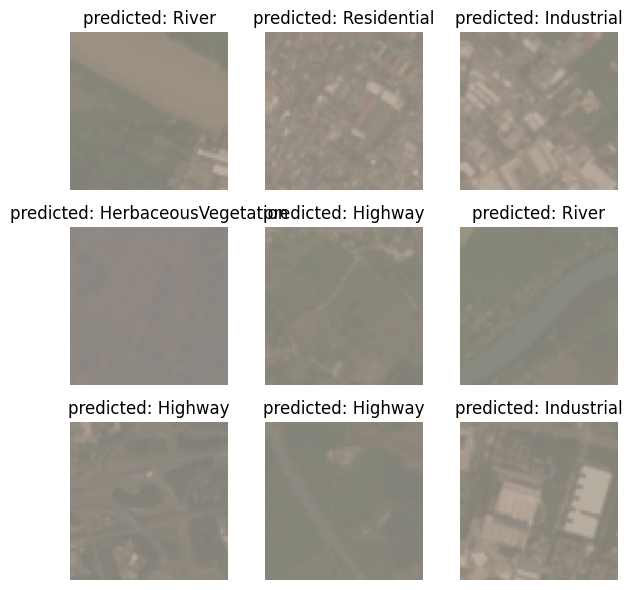

In [29]:
## GoogLeNet Quantized
model_name = "GoogLeNet"
weights = qmodels.GoogLeNet_QuantizedWeights.DEFAULT
model_rn = qmodels.googlenet(weights=weights, quantize=True)
num_ftrs = model_rn.fc.in_features
new_model = google_net_features(model_rn,num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [30]:
## Save GoogLeNet Quantized
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\GoogLeNet.pth
Successfully exported model


## Stats Quantized

In [31]:
stats = pd.DataFrame(stats_lst, columns = ['Model', 'Epoch', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Val Accuracy'])

In [32]:
stats.to_csv('Stats.csv')